In [1]:
#Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans, AffinityPropagation, OPTICS, MeanShift
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from utils import *

In [2]:
def generate_noisy_data(original_data, n_vectors, scale_factor):
    """
    Generate n_vectors of noisy data from the given original_data using a scaling factor.
    
    Args:
        original_data (numpy.ndarray): The original data array.
        n_vectors (int): The number of noisy data vectors to generate.
        scale_factor (float): The scaling factor for the standard deviation of the noise.
        
    Returns:
        numpy.ndarray: A 2D array containing the n_vectors of noisy data,
                        with each row representing one noisy data vector.
    """
    mean = np.mean(original_data)
    std_dev = np.std(original_data)
    
    noisy_data_list = []
    for i in range(n_vectors):
        scaled_std_dev = std_dev * (1 + i * scale_factor)
        noise = np.random.normal(mean, scaled_std_dev, original_data.shape)
        noisy_data = original_data + noise
        noisy_data_list.append(noisy_data)
    
    return np.vstack(noisy_data_list)

# def generate_noisy_data(original_data, n_vectors):
#     """
#     Generate n_vectors of noisy data from the given original_data.
    
#     Args:
#         original_data (numpy.ndarray): The original data array.
#         n_vectors (int): The number of noisy data vectors to generate.
        
#     Returns:
#         numpy.ndarray: A 2D array containing the n_vectors of noisy data,
#                         with each row representing one noisy data vector.
#     """
#     mean = np.mean(original_data)
#     std_dev = np.std(original_data)
    
#     noisy_data_list = []
#     for _ in range(n_vectors):
#         noise = np.random.normal(mean, std_dev, original_data.shape)
#         noisy_data = original_data + noise
#         noisy_data_list.append(noisy_data)
    
#     return np.vstack(noisy_data_list)

def get_dist(data, labels):
    """
    Inputs
        data: input data for clustering
        labels: labels of clustering output
    
    Find cluster centers, distances between clusters and distances between data points and centers 
    Use this to complete calculations AFTER clustering is complete
    This is based on euclidean metric, NOT the optimization methods or representation sample of the given algorithm
    
    Outputs:
        cluster_centers: center of each cluster. expect this as a 1xn array, where n is the number of 
                columns in the data set used
        cluster_distances: distance from the cluster of each cluster to another one. expect this as an cxc matrix,
                where c is the number of clusters. the diagonal is always 0 (distance to itself)
        data_cluster_distances: distance from each sample to the center of each cluster. Expect this as a mxc matrix,
                where m is number of samples and c is the number of clusters
    """

    # Get the number of clusters (excluding noise)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    # Calculate cluster centers
    if -1 in labels:
        cluster = np.array([data_scaled[labels == i].mean(axis=0) for i in range(n_clusters)])
        outlier = np.array([data_scaled[labels == -1].mean(axis=0) ])
        cluster_centers = np.vstack((cluster, outlier))
    else:
        cluster_centers = np.array([data_scaled[labels == i].mean(axis=0) for i in range(n_clusters)])

#     print("Cluster Centers:")
#     print(cluster_centers)

    # Compute the pairwise distances between cluster centers
    cluster_distances = cdist(cluster_centers, cluster_centers, metric='euclidean')
    # Print the distances between cluster centers
    print("Distances between cluster centers:")
    print(cluster_distances)

    # Compute the distances between each data point and cluster centers
    data_cluster_distances = cdist(data_scaled, cluster_centers, metric='euclidean')

    # Print the distances between each data point and cluster centers
    print("\nDistances between data points and cluster centers:")
    for i, distances in enumerate(data_cluster_distances):
        print(f"Data point {i}: {distances}")
        
    return 

# # Calculate cluster centers for AgglomerativeClustering
# cluster_centers = np.array([data_scaled[labels == i].mean(axis=0) for i in range(agg.n_clusters_)])

# print("\nAgglomerativeClustering Cluster Centers:")
# print(cluster_centers)

# # Compute the pairwise distances between cluster centers
# cluster_distances = cdist(cluster_centers, cluster_centers, metric='euclidean')
# # Print the distances between cluster centers
# print("Distances between cluster centers:")
# print(cluster_distances)

# # Compute the distances between each data point and cluster centers
# data_cluster_distances = cdist(data_scaled, cluster_centers, metric='euclidean')

# # Print the distances between each data point and cluster centers
# print("\nDistances between data points and cluster centers:")
# for i, distances in enumerate(data_cluster_distances):
#     print(f"Data point {i}: {distances}")

In [3]:
# Load the dataset
biomass_data = pd.read_csv('site_data.csv')

# Transpose the DataFrame to have products as rows and locations as columns
data_transposed = biomass_data.set_index(['dataset', 'site_name', 'site_id', 'X', 'Y']).T

# Remove non-numeric rows
data_transposed_numeric = data_transposed.select_dtypes(include=[np.number])

# Replace 'NA' with NaN
data_transposed_numeric = data_transposed_numeric.replace('NA', np.nan)

# Drop rows with all NaN values
data_transposed_numeric = data_transposed_numeric.dropna(axis=1, how='all')

# Impute missing values with column mean
imputer = SimpleImputer(strategy='mean')
# Impute missing values with ROW mean (must use transposed df and axis=1 for rows)
data_imputed = data_transposed_numeric.T.fillna(data_transposed_numeric.mean(axis=1)).T

data_imputed

dataset                    NEON                                             \
site_name        Harvard Forest Smithsonian Conservation Biology Institute   
site_id                    HARV                                       SCBI   
X                   -72.172660                                 -78.139500    
Y                     42.536900                                  38.892920   
ESA CCI               21.046901                                  21.046901   
Chopping et al.       18.783055                                  18.783055   
GEDI L4B             164.080719                                 334.279755   
Liu et al.            37.921211                                 115.212837   
LT-GNN                31.403246                                  31.403246   
Menlove & Healey     114.922806                                 106.782768   
Xu et al.             69.325028                                  69.325028   

dataset                                                         \
site_name        Ordway-Swisher Biological Station      UNDERC   
site_id                                       OSBS        UNDE   
X                                      -81.993430  -89.537250    
Y                                        29.689270   46.233880   
ESA CCI                                  21.046901   21.046901   
Chopping et al.                          18.783055   18.783055   
GEDI L4B                                 63.379155  155.069643   
Liu et al.                               69.890287  139.331772   
LT-GNN                                   31.403246   31.403246   
Menlove & Healey                         42.734001   91.699257   
Xu et al.                                69.325028   69.325028   

dataset                                                        \
site_name        Konza Prairie Biological Station   Oak Ridge   
site_id                                      KONZ        ORNL   
X                                     -96.563090  -84.282600    
Y                                       39.100770   35.964120   
ESA CCI                                 21.046901   21.046901   
Chopping et al.                         18.783055   18.783055   
GEDI L4B                                 7.477551  162.482702   
Liu et al.                              10.838812   91.845345   
LT-GNN                                  31.403246   31.403246   
Menlove & Healey                        10.135107  115.705890   
Xu et al.                               69.325028   69.325028   

dataset                                                 \
site_name        Talladega National Forest   Woodworth   
site_id                               TALL        WOOD   
X                              -87.393270  -99.241356    
Y                                32.950460   47.128228   
ESA CCI                          21.046901   21.046901   
Chopping et al.                  18.783055   18.783055   
GEDI L4B                        228.355491    4.161302   
Liu et al.                       85.784576    9.719982   
LT-GNN                           31.403246   31.403246   
Menlove & Healey                125.903267    0.000000   
Xu et al.                        69.325028   69.325028   

dataset                                                                    \
site_name        Central Plains Experimental Range LBJ National Grassland   
site_id                                       CPER                   CLBJ   
X                                      -104.745602            -97.570000    
Y                                        40.815534              33.401230   
ESA CCI                                  21.046901              21.046901   
Chopping et al.                           0.000000              18.783055   
GEDI L4B                                  1.268689              17.868778   
Liu et al.                                9.621728              11.764260   
LT-GNN                                   31.403246              31.403246   
Menlove & Healey      

In [4]:
biomass_data

,dataset,site_name,site_id,X,Y,ESA CCI,Chopping et al.,GEDI L4B,Liu et al.,LT-GNN,Menlove & Healey,Xu et al.
0,NEON,Harvard Forest,HARV,-72.17266,42.53690,NaN,NaN,164.080719,37.921211,NaN,114.922806,NaN
1,NEON,Smithsonian Conservation Biology Institute,SCBI,-78.13950,38.89292,NaN,NaN,334.279755,115.212837,NaN,106.782768,NaN
2,NEON,Ordway-Swisher Biological Station,OSBS,-81.99343,29.68927,NaN,NaN,63.379155,69.890287,NaN,42.734001,NaN
3,NEON,Guanica Forest,GUAN,-66.86870,17.96955,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NEON,UNDERC,UNDE,-89.53725,46.23388,NaN,NaN,155.069643,139.331772,NaN,91.699257,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
502,Ameriflux,NEON University of Notre Dame Environmental Re...,US-xUN,-89.53730,46.23390,NaN,NaN,155.035292,139.331772,NaN,91.699257,NaN
503,Ameriflux,NEON Woodworth (WOOD),US-xWD,-99.24140,47.12820,NaN,NaN,4.150213,9.719900,NaN,0.000000,NaN
504,Ameriflux,NEON Wind River Experimental Forest (WREF),US-xWR,-121.95190,45.82050,244.415145,NaN,357.726868,194.783264,NaN,320.595123,819.682068
505,Ameriflux,NEON Yellowstone Northern Range (Frog Rock) (Y...,US-xYE,-110.53910,44.95350,7.986143,NaN,37.207724,59.854660,NaN,36.563770,79.867683


In [5]:
df=data_imputed
# Specify the mean and standard deviation of the Gaussian noise
mean = np.mean(df.loc['Liu et al.'])
std_dev = np.std(df.loc['Liu et al.'])
var = np.var(df.loc['Liu et al.'])

# # Generate random noise from a Gaussian distribution
# noise = np.random.normal(mean, std_dev, df.loc['Liu et al.'].shape)
# # Add the noise to the dataset
# noisy_data_1 = df.loc['Liu et al.'] + noise   

In [6]:
# Generate 10 vectors of noisy data from the first dataset
noisy_data_1 = generate_noisy_data(df.loc['Liu et al.'], 10, 0)

# Generate 10 vectors of noisy data from the second dataset
noisy_data_2 = generate_noisy_data(df.loc['GEDI L4B'], 10, 0)

# Combine the noisy data vectors from both datasets
Liu_Gedi = np.vstack((noisy_data_1, noisy_data_2))
Liu_Gedi

array([[ 80.37746514, 147.63112272, 101.84016801, ..., 251.70216458,
        105.25915829,  20.35931027],
       [ 64.21293226, 119.06283661, 114.79243612, ..., 216.92480211,
        121.47321931,  76.45874299],
       [ 55.5613546 , 178.35690613,  56.32558345, ..., 202.83926022,
        136.70490511,  26.91481644],
       ...,
       [139.33488385, 381.22853011, 127.48914225, ..., 433.01487146,
        170.38074273,  33.06999967],
       [412.71539651, 459.43440045,  43.09940568, ..., 338.92500515,
        104.83893671,  21.07628268],
       [192.08719618, 325.97096681,  84.41454095, ..., 396.54557702,
        133.92607561, 113.78528562]])

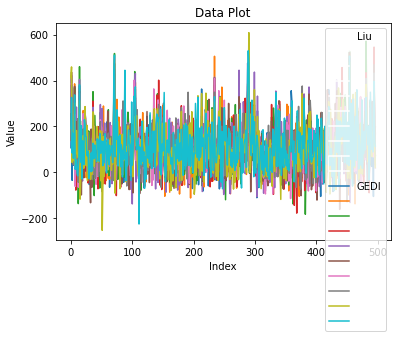

In [7]:
# Plot first 10 rows in red
for i in range(10):
    plt.plot(Liu_Gedi[i], color='w')

# Plot next 10 rows in blue
for i in range(10, 20):
    plt.plot(Liu_Gedi[i])

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Data Plot')
plt.legend(['Liu','','','','','','','','','', 'GEDI','','','','','','','','',''])

plt.show()

In [8]:
# Print summary statistics
print("Summary Statistics: Liu")
print("Mean:", np.mean(Liu_Gedi[1:10]))
print("Median:", np.median(Liu_Gedi[1:10]))
print("Standard Deviation:", np.std(Liu_Gedi[1:10]))
print("Variance:", np.var(Liu_Gedi[1:10]))
print("Minimum:", np.min(Liu_Gedi[1:10]))
print("Maximum:", np.max(Liu_Gedi[1:10]))
print("Range:", np.max(Liu_Gedi[1:10])-np.min(Liu_Gedi[1:10]))
print()

Summary Statistics: Liu
Mean: 90.29155361102279
Median: 84.46383620646523
Standard Deviation: 59.22883001587104
Variance: 3508.054305048946
Minimum: -86.55311459721065
Maximum: 334.74876066749545
Range: 421.3018752647061



In [9]:
G=Liu_Gedi[10:20]
# Print summary statistics
print("Summary Statistics: Gedi")
print("Mean:", np.mean(G))
print("Median:", np.median(G))
print("Standard Deviation:", np.std(G))
print("Variance:", np.var(G))
print("Minimum:", np.min(G))
print("Maximum:", np.max(G))
print("Range:", np.max(G)-np.min(G))
print()

Summary Statistics: Gedi
Mean: 109.94939942317626
Median: 98.03526413237797
Standard Deviation: 101.95674173884316
Variance: 10395.177186001163
Minimum: -253.0838538298044
Maximum: 608.7640409292819
Range: 861.8478947590863



In [10]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(Liu_Gedi)

agg = AgglomerativeClustering(n_clusters=2, linkage='ward')
clusters = agg.fit_predict(data_scaled)
labels = agg.labels_
print("Cluster labels:", clusters)

get_dist(data_scaled, labels)

Cluster labels: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Distances between cluster centers:
[[ 0.         17.12714477]
 [17.12714477  0.        ]]

Distances between data points and cluster centers:
Data point 0: [23.44714396 15.88516409]
Data point 1: [23.45409332 15.42562059]
Data point 2: [23.22448159 15.11338154]
Data point 3: [23.26484467 15.2827561 ]
Data point 4: [22.21311971 15.22193478]
Data point 5: [22.39706478 15.28714802]
Data point 6: [22.48398973 14.94141868]
Data point 7: [23.17861839 15.70216521]
Data point 8: [23.56010047 15.59119728]
Data point 9: [22.77673032 15.10728581]
Data point 10: [24.17268245 29.52389225]
Data point 11: [25.10277125 30.15558984]
Data point 12: [25.58963667 30.60523212]
Data point 13: [25.14536411 30.28812522]
Data point 14: [25.5154556  31.03486931]
Data point 15: [24.84079327 30.95959206]
Data point 16: [23.606983   28.37445855]
Data point 17: [24.70805151 29.49347603]
Data point 18: [24.95196415 30.36802301]
Data point 19: [23.54671366 29.

In [21]:
# DBSCAN clustering
dbscan = DBSCAN(eps=22, min_samples=2)  # Adjust the parameters as needed
clusters = dbscan.fit_predict(data_scaled)
if -1 in clusters:
    print("noise found during clustering, contained in cluster -1")
labels = dbscan.labels_
print("DBSCAN Cluster labels:", clusters)

get_dist(data_scaled, labels)
#at eps=23, this is the same as OPTICS?

noise found during clustering, contained in cluster -1
DBSCAN Cluster labels: [-1  0  0  0 -1 -1  1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Distances between cluster centers:
[[ 0.         14.36058092 15.80639115]
 [14.36058092  0.         15.35682622]
 [15.80639115 15.35682622  0.        ]]

Distances between data points and cluster centers:
Data point 0: [19.11635395 19.83414078 19.62252281]
Data point 1: [12.46610691 19.7577053  20.5098451 ]
Data point 2: [13.00591692 19.0002689  20.23687972]
Data point 3: [13.04610855 19.02788377 20.34943737]
Data point 4: [19.09798424 18.46192315 18.47893599]
Data point 5: [18.80737198 18.93630012 18.63632009]
Data point 6: [19.16580122 12.89714892 19.51700125]
Data point 7: [19.34879572 12.47460466 20.51847683]
Data point 8: [18.88676194 19.02181876 19.77018245]
Data point 9: [19.12132034 12.91114475 19.85509949]
Data point 10: [30.9049296  30.56144637 24.69595093]
Data point 11: [30.9693025  31.32368377 25.66305943]
Data point 12: [31.7348984  3

In [12]:
#OPTICS clustering

optics = OPTICS(min_samples=2)
clusters = optics.fit_predict(data_scaled)
labels = optics.labels_
print("OPTICS Cluster labels:", clusters)

get_dist(data_scaled, labels)

OPTICS Cluster labels: [ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Distances between cluster centers:
[[ 0.         17.12714477]
 [17.12714477  0.        ]]

Distances between data points and cluster centers:
Data point 0: [15.88516409 23.44714396]
Data point 1: [15.42562059 23.45409332]
Data point 2: [15.11338154 23.22448159]
Data point 3: [15.2827561  23.26484467]
Data point 4: [15.22193478 22.21311971]
Data point 5: [15.28714802 22.39706478]
Data point 6: [14.94141868 22.48398973]
Data point 7: [15.70216521 23.17861839]
Data point 8: [15.59119728 23.56010047]
Data point 9: [15.10728581 22.77673032]
Data point 10: [29.52389225 24.17268245]
Data point 11: [30.15558984 25.10277125]
Data point 12: [30.60523212 25.58963667]
Data point 13: [30.28812522 25.14536411]
Data point 14: [31.03486931 25.5154556 ]
Data point 15: [30.95959206 24.84079327]
Data point 16: [28.37445855 23.606983  ]
Data point 17: [29.49347603 24.70805151]
Data point 18: [30.36802301 24.95196415]
Data

In [13]:
#MeanShift clustering

meanshift = MeanShift()
clusters = meanshift.fit_predict(data_scaled)
labels= meanshift.labels_
print("Cluster labels:", clusters)

get_dist(data_scaled, labels)

Cluster labels: [ 0  0  0  0  0  0  0  0  0  0 10  7  2  5  3  6  4  9  1  8]
Distances between cluster centers:
[[ 0.         30.36802301 30.60523212 31.03486931 28.37445855 30.28812522
  30.95959206 30.15558984 29.89957733 29.49347603 29.52389225]
 [30.36802301  0.         39.03299769 37.95957175 35.89464801 37.58778995
  36.65923722 37.84650392 35.043606   36.83249882 36.24643905]
 [30.60523212 39.03299769  0.         38.46643007 36.95738416 37.49112694
  37.23161339 36.19879967 37.08121328 37.98688734 37.06171415]
 [31.03486931 37.95957175 38.46643007  0.         35.84675823 37.65726048
  37.49617683 37.98638737 36.8678653  37.99423815 36.73574916]
 [28.37445855 35.89464801 36.95738416 35.84675823  0.         34.86124945
  37.61050676 36.87207443 34.71545105 36.01524184 35.44687743]
 [30.28812522 37.58778995 37.49112694 37.65726048 34.86124945  0.
  37.20930322 38.92034497 35.68569497 37.87773665 37.12262513]
 [30.95959206 36.65923722 37.23161339 37.49617683 37.61050676 37.20930322